**calcul des handcrafted features**

In [ ]:
import pandas as pd
import numpy as np
import os

TRACKER_FILE = r"C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_results_yolo.txt"
OUTPUT_FEATURES_FILE = r"C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_features.txt"
WINDOW_SIZE = 5

df = pd.read_csv(TRACKER_FILE, header=None)
df.columns = ['frame', 'track_id', 'x', 'y', 'width', 'height', 'conf', 'cls']

# Calculer le centre des bounding boxes
df['x_center'] = df['x'] + df['width'] / 2
df['y_center'] = df['y'] + df['height'] / 2

df['aspect_ratio'] = df['width'] / df['height']

movement_features = ['interframe_distance', 'velocity', 'velocity_direction',
                     'acceleration', 'acceleration_direction']
for f in movement_features:
    df[f] = 0.0

for track_id, group in df.groupby('track_id'):
    group_sorted = group.sort_values(by='frame')
    x_diff = group_sorted['x_center'].diff()
    y_diff = group_sorted['y_center'].diff()
    ts_diff = group_sorted['frame'].diff().replace(0, np.nan)

    distance = np.sqrt(x_diff**2 + y_diff**2)
    velocity = distance / ts_diff
    velocity_direction = np.degrees(np.arctan2(y_diff, x_diff))

    vx = x_diff / ts_diff
    vy = y_diff / ts_diff
    ax = vx.diff() / ts_diff
    ay = vy.diff() / ts_diff

    acceleration = np.sqrt(ax**2 + ay**2)
    acceleration_direction = np.degrees(np.arctan2(ay, ax))

    distance[ts_diff > 150] = 0
    velocity[ts_diff > 150] = 0
    velocity_direction[ts_diff > 150] = 0
    acceleration[ts_diff > 150] = 0
    acceleration_direction[ts_diff > 150] = 0

    distance = distance.fillna(0)
    velocity = velocity.fillna(0)
    velocity_direction = velocity_direction.fillna(0)
    acceleration = acceleration.fillna(0)
    acceleration_direction = acceleration_direction.fillna(0)

    df.loc[group_sorted.index, 'interframe_distance'] = distance
    df.loc[group_sorted.index, 'velocity'] = velocity
    df.loc[group_sorted.index, 'velocity_direction'] = velocity_direction
    df.loc[group_sorted.index, 'acceleration'] = acceleration
    df.loc[group_sorted.index, 'acceleration_direction'] = acceleration_direction

for f in movement_features:
    df[f+'_mean'] = df[f].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    df[f+'_max'] = df[f].rolling(window=WINDOW_SIZE, min_periods=1, center=True).max()
    df[f+'_min'] = df[f].rolling(window=WINDOW_SIZE, min_periods=1, center=True).min()
    df[f+'_std'] = df[f].rolling(window=WINDOW_SIZE, min_periods=1, center=True).std().fillna(0)

df.to_csv(OUTPUT_FEATURES_FILE, sep=' ', index=False, float_format='%.3f')
print(f"Fichier features sauvegardé : {OUTPUT_FEATURES_FILE}")

**Standardisation des features du tracking avec le scaler entraîné**

In [1]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler


train_file = r"C:\Users\rouat\Desktop\final\train\annotations_train_with_features_multi_frame.txt"
features_file = r"C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_features.txt"


train_df = pd.read_csv(train_file, sep=' ')

exclude_cols = ['behavior', 'object_id', 'timestamp', 'frame', 'track_id', 'cls', 'conf']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

scaler = StandardScaler()
scaler.fit(train_df[feature_cols])


features_df = pd.read_csv(features_file, sep=' ')

features_df_scaled = features_df.copy()
common_cols = [col for col in feature_cols if col in features_df.columns]  
features_df_scaled[common_cols] = scaler.transform(features_df[common_cols])


output_file = os.path.join(os.path.dirname(features_file), "tracking_features_scaled.txt")
features_df_scaled.to_csv(output_file, sep=' ', index=False, float_format='%.3f')

print(f" Fichier standardisé avec le scaler du train sauvegardé : {output_file}")


 Fichier standardisé avec le scaler du train sauvegardé : C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_features_scaled.txt


**Prédiction des comportements**

In [3]:
import pandas as pd
import os
import pickle


features_file = r"C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_features_scaled.txt"
model_file    = r"C:\Users\rouat\Desktop\final\train\best_xgb_model.pkl"

features_df = pd.read_csv(features_file, sep=' ')

feature_cols = ['x_center', 'y_center', 'width', 'height',
                'aspect_ratio', 'interframe_distance',
                'velocity', 'velocity_direction',
                'acceleration', 'acceleration_direction',
                'interframe_distance_mean', 'interframe_distance_max', 'interframe_distance_min', 'interframe_distance_std',
                'velocity_mean', 'velocity_max', 'velocity_min', 'velocity_std',
                'velocity_direction_mean', 'velocity_direction_max', 'velocity_direction_min', 'velocity_direction_std',
                'acceleration_mean', 'acceleration_max', 'acceleration_min', 'acceleration_std',
                'acceleration_direction_mean', 'acceleration_direction_max', 'acceleration_direction_min', 'acceleration_direction_std']

# Charger le modèle sauvegardé
with open(model_file, "rb") as f:
    best_model = pickle.load(f)

# Prédire les comportements
X = features_df[feature_cols]
features_df['predicted_behavior'] = best_model.predict(X)

# Sauvegarder 
output_file = os.path.join(os.path.dirname(features_file), "tracking_features_with_behavior.txt")
features_df.to_csv(output_file, sep=' ', index=False, float_format='%.3f')

print(f" Fichier avec les comportements prédits sauvegardé : {output_file}")


 Fichier avec les comportements prédits sauvegardé : C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_features_with_behavior.txt


**Fusion des résultats du tracking avec les comportements prédits**

In [17]:
import pandas as pd

TRACKER_FILE = r"C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_results_yolo.txt"
FEATURES_FILE = r"C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_features_with_behavior.txt"
OUTPUT_FILE = r"C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_with_behavior.csv"

yolo_df = pd.read_csv(TRACKER_FILE, header=None,
                      names=["frame", "track_id", "x", "y", "w", "h", "conf", "cls"])

behavior_df = pd.read_csv(FEATURES_FILE, sep="\s+", engine='python')

behavior_df = behavior_df.rename(columns={"predicted_behavior": "behavior"})
behavior_df = behavior_df[["frame", "track_id", "behavior"]]

yolo_df["frame"] = yolo_df["frame"].astype(int)
yolo_df["track_id"] = yolo_df["track_id"].astype(int)

behavior_df["frame"] = behavior_df["frame"].astype(int)
behavior_df["track_id"] = behavior_df["track_id"].astype(int)

merged_df = pd.merge(
    yolo_df[["frame", "track_id", "x", "y", "w", "h"]],
    behavior_df,
    on=["frame", "track_id"],
    how="left"
)

merged_df["behavior"] = merged_df["behavior"].fillna(-1).astype(int)

merged_df.to_csv(OUTPUT_FILE, index=False)
print(f"Fichier final avec behavior sauvegardé dans : {OUTPUT_FILE}")


<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rouat\AppData\Local\Temp\ipykernel_15620\1157188258.py:13: SyntaxWarning: invalid escape sequence '\s'
  behavior_df = pd.read_csv(FEATURES_FILE, sep="\s+", engine='python')


Fichier final avec behavior sauvegardé dans : C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_with_behavior.csv


In [23]:
import pandas as pd

file_path = r"C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_with_behavior.csv"

df = pd.read_csv(file_path)

df['behavior'] = df['behavior'] + 1

df.to_csv(file_path, index=False)

print("La colonne 'behavior' a été incrémentée de +1 avec succès !")


La colonne 'behavior' a été incrémentée de +1 avec succès !


**rapport de classification et matrices de confusion**

=== Rapport de classification ===
              precision    recall  f1-score   support

         1.0       0.18      0.19      0.19       134
         2.0       0.80      0.92      0.85      3440
         3.0       0.37      0.21      0.26       502
         4.0       0.58      0.71      0.64       930
         5.0       0.46      0.67      0.55       110
         6.0       0.52      0.45      0.48        92
         7.0       1.00      0.88      0.93      4466

    accuracy                           0.82      9674
   macro avg       0.56      0.57      0.56      9674
weighted avg       0.83      0.82      0.82      9674



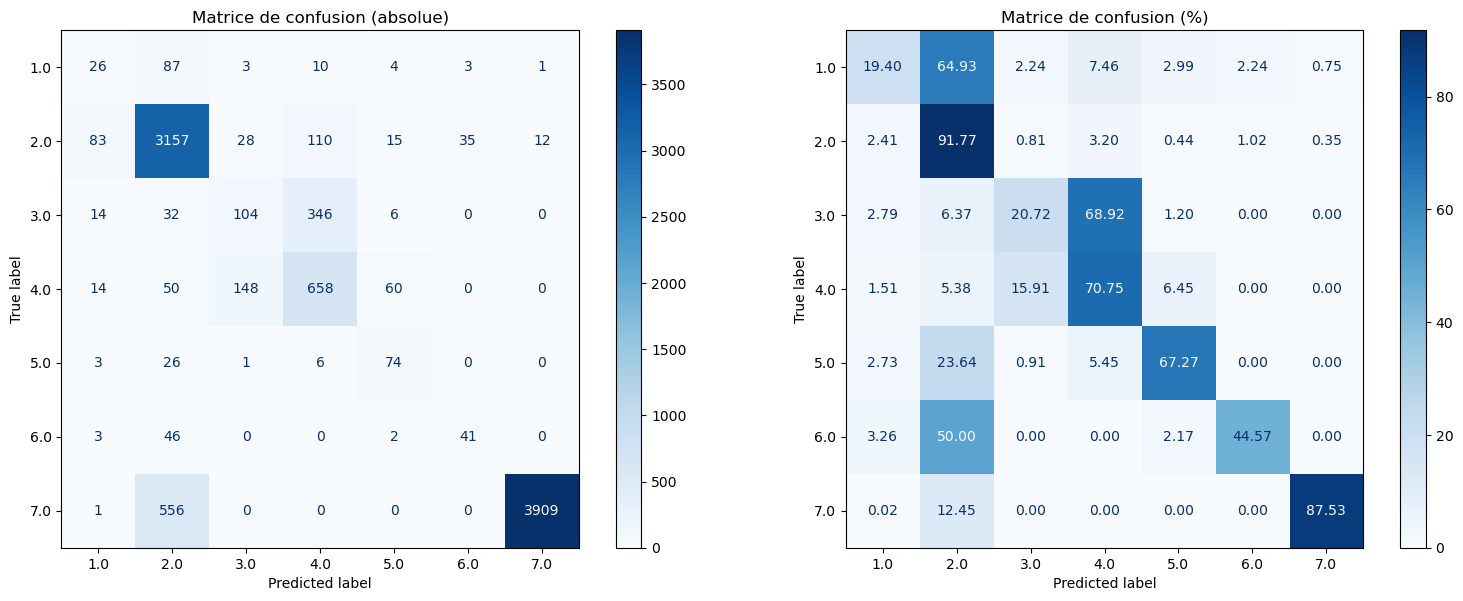

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

gt_file = r"C:\Users\rouat\Desktop\final\mot\test\gt_with_behavior.txt"
pipeline_file = r"C:\Users\rouat\Desktop\final\end_to_end_pipeline\tracking_results\tracking_with_behavior.csv"

gt_cols = ["frame","object_id","x","y","w","h","conf","cls","vis","behavior"]
gt_df = pd.read_csv(gt_file, header=None, names=gt_cols)
pipeline_df = pd.read_csv(pipeline_file)

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    
    return interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0

matched_gt_behaviors = []
matched_pipeline_behaviors = []

iou_threshold = 0.5
frames = sorted(gt_df['frame'].unique())

for frame in frames:
    gt_frame = gt_df[gt_df['frame'] == frame]
    pipe_frame = pipeline_df[pipeline_df['frame'] == frame]
    
    for _, gt_row in gt_frame.iterrows():
        gt_box = [gt_row['x'], gt_row['y'], gt_row['w'], gt_row['h']]
        best_iou = 0
        best_pipe_row = None
        
        for _, pipe_row in pipe_frame.iterrows():
            pipe_box = [pipe_row['x'], pipe_row['y'], pipe_row['w'], pipe_row['h']]
            current_iou = iou(gt_box, pipe_box)
            if current_iou > best_iou:
                best_iou = current_iou
                best_pipe_row = pipe_row
        
        if best_iou >= iou_threshold:
            matched_gt_behaviors.append(gt_row['behavior'])
            matched_pipeline_behaviors.append(best_pipe_row['behavior'])

report = classification_report(
    matched_gt_behaviors,
    matched_pipeline_behaviors,
    digits=2,
    zero_division=0
)
print("=== Rapport de classification ===")
print(report)

# --- Matrices de confusion ---
cm_abs = confusion_matrix(matched_gt_behaviors, matched_pipeline_behaviors)
cm_percent = cm_abs.astype('float') / cm_abs.sum(axis=1)[:, np.newaxis] * 100
cm_percent = np.nan_to_num(cm_percent)  

labels = np.unique(matched_gt_behaviors)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matrice absolue
disp_abs = ConfusionMatrixDisplay(confusion_matrix=cm_abs, display_labels=labels)
disp_abs.plot(cmap="Blues", values_format="d", ax=axes[0])
axes[0].set_title("Matrice de confusion (absolue)")

# Matrice en pourcentage
disp_pct = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=labels)
disp_pct.plot(cmap="Blues", values_format=".2f", ax=axes[1])
axes[1].set_title("Matrice de confusion (%)")

plt.tight_layout()
plt.show()
